In [1]:
from utils import evaluate_with_seg, get_precision_recall_curve, get_evaluation_data_from_paths
from plot_utils import plot_seg
import SimpleITK as sitk
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import precision_score
from matplotlib import cm
import matplotlib.colors as mcolors
import seaborn as sns
from statannotations.Annotator import Annotator
from scipy.stats import wilcoxon

In [2]:
data_dir = '/path/to/dataset/here/'

In [3]:
models = ['BASE', 'TISSUE', 'DTI']
norm = mcolors.Normalize(vmin=0, vmax=3)
colors = [cm.viridis(norm(i)) for i in range(3)]

In [4]:
df_results = pd.DataFrame()
for p in os.listdir(data_dir):
    if not os.path.isdir(os.path.join(data_dir, p)) or p == 'simulations':
        continue
    print(f"Evaluating {p}")
    for model in models:
        
        path_results = os.path.join(data_dir, p, model)
        tissue_path = os.path.join(data_dir, p, 'ATLAS', 'FOLLOWUP_TISSUE_to_atlas_bspline.nii.gz')
        
        ### Evaluate against followup S'_2                
        segpath = os.path.join(data_dir, p, 'ATLAS', 'FOLLOWUP_TUMOR_to_atlas_bspline.nii.gz')

        dsc, ap = evaluate_with_seg(path_results, segpath, tissue_path)
        
        df_results = pd.concat([df_results, pd.DataFrame({
            'Patient': p,
            'Method': model,
            '$DSC_v$': dsc,
            'AP': ap,
            'Moment': "$S'_2$",
            'logdir': path_results,
            'segpath': segpath,
            'tissue_path': tissue_path
        }, index=[0])], ignore_index=True)

        ### Evaluate against baseline S'_0        
        segpath = os.path.join(data_dir, p, 'ATLAS', 'BASE_TUMOR_to_ATLAS_bspline.nii.gz')

        dsc, ap = evaluate_with_seg(path_results, segpath)

        df_results = pd.concat([df_results, pd.DataFrame({
            'Patient': p,
            'Method': model,
            '$DSC_v$': dsc,
            'AP': ap,
            'Moment': "$S'_0$",
            'logdir': path_results,
            'segpath': segpath,
            'tissue_path': tissue_path
            
        }, index=[0])], ignore_index=True)

Evaluating pat_01
Evaluating pat_02
Evaluating pat_03
Evaluating pat_04
Evaluating pat_05
Evaluating pat_06
Evaluating pat_07
Evaluating pat_08
Evaluating pat_09
Evaluating pat_10
Evaluating pat_11
Evaluating pat_12
Evaluating pat_13
Evaluating pat_14


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$S'_2$_TISSUE vs. $S'_2$_DTI: Wilcoxon test (paired samples), P_val:3.662e-04 Stat=2.000e+00
$S'_0$_BASE vs. $S'_0$_TISSUE: Wilcoxon test (paired samples), P_val:1.726e-01 Stat=3.000e+01
$S'_0$_TISSUE vs. $S'_0$_DTI: Wilcoxon test (paired samples), P_val:1.221e-03 Stat=5.000e+00
$S'_2$_BASE vs. $S'_2$_TISSUE: Wilcoxon test (paired samples), P_val:4.263e-01 Stat=3.900e+01
$S'_2$_BASE vs. $S'_2$_DTI: Wilcoxon test (paired samples), P_val:3.662e-04 Stat=2.000e+00
$S'_0$_BASE vs. $S'_0$_DTI: Wilcoxon test (paired samples), P_val:6.257e-01 Stat=4.400e+01


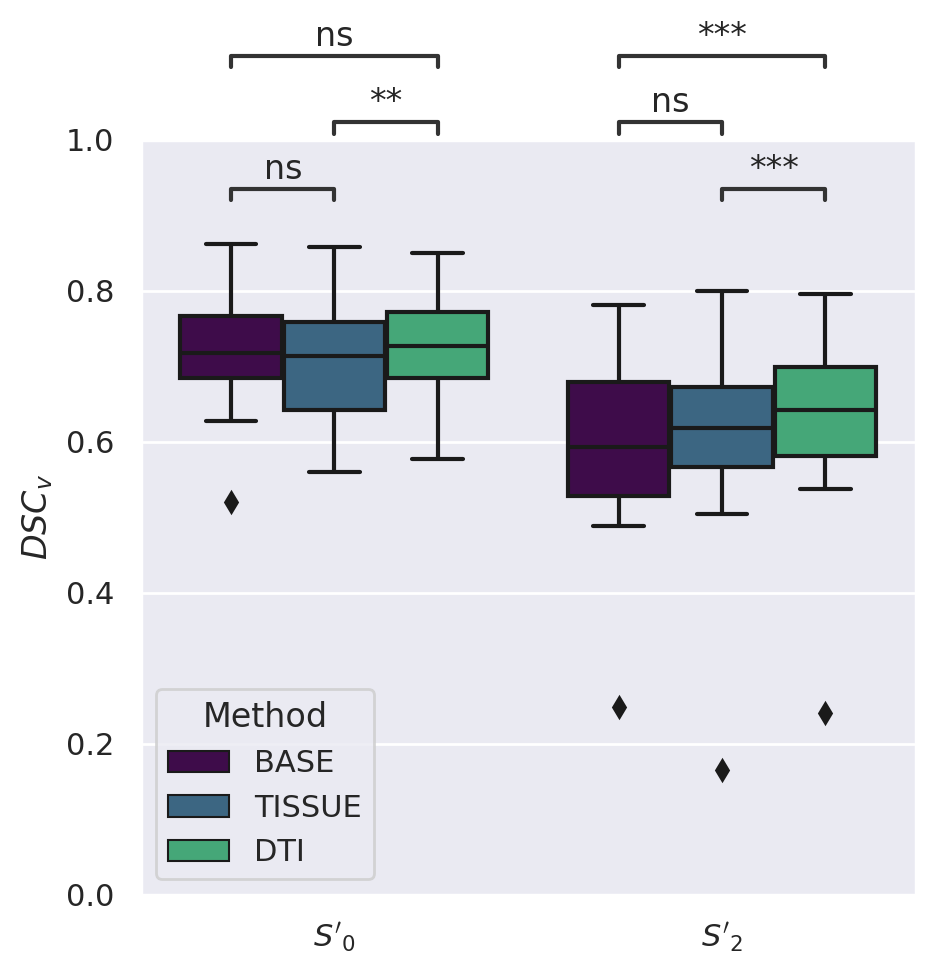

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

$S'_2$_TISSUE vs. $S'_2$_DTI: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
$S'_0$_BASE vs. $S'_0$_TISSUE: Wilcoxon test (paired samples), P_val:7.849e-02 Stat=2.400e+01
$S'_0$_TISSUE vs. $S'_0$_DTI: Wilcoxon test (paired samples), P_val:8.545e-04 Stat=4.000e+00
$S'_2$_BASE vs. $S'_2$_TISSUE: Wilcoxon test (paired samples), P_val:3.528e-02 Stat=1.900e+01
$S'_2$_BASE vs. $S'_2$_DTI: Wilcoxon test (paired samples), P_val:1.221e-04 Stat=0.000e+00
$S'_0$_BASE vs. $S'_0$_DTI: Wilcoxon test (paired samples), P_val:9.515e-01 Stat=5.100e+01


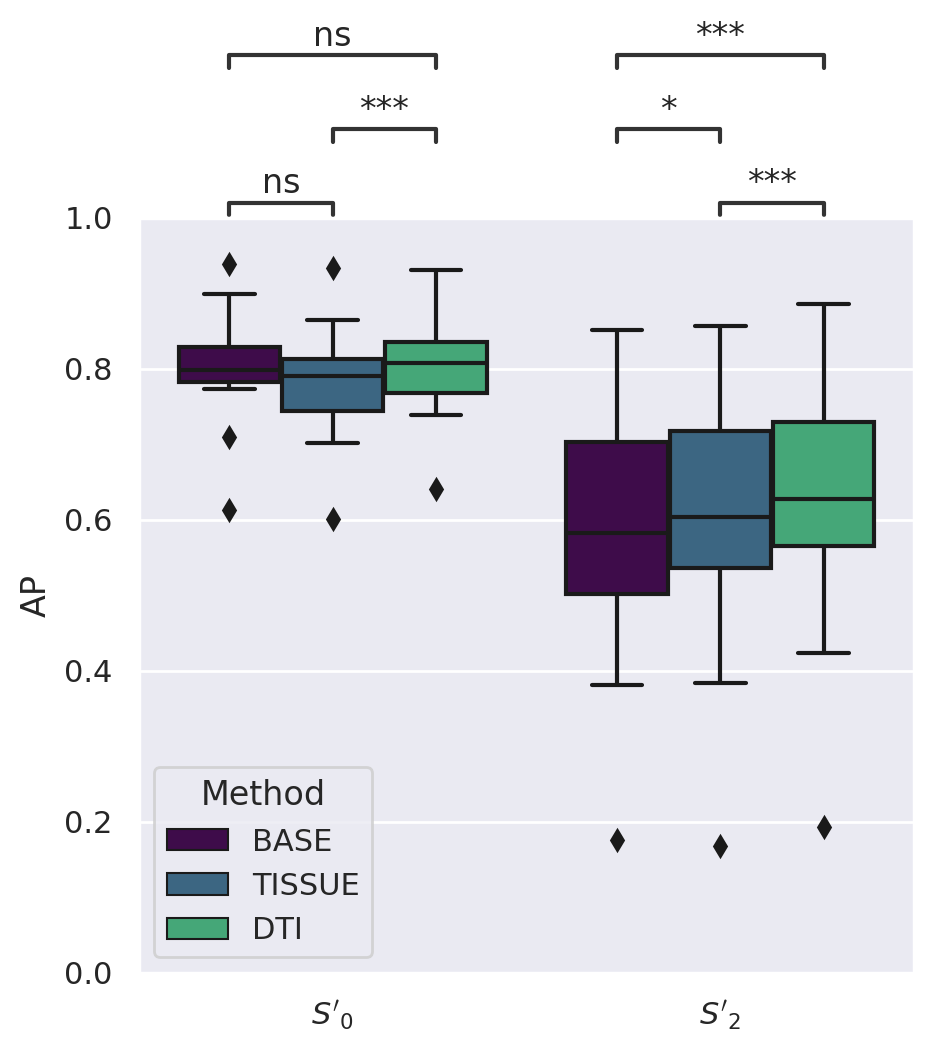

In [8]:
sns.set(rc = {'figure.figsize':(5,5), 'savefig.dpi': 200, 'figure.dpi': 200})

ax = sns.boxplot(data=df_results, y='$DSC_v$', x='Moment', hue='Method', order=["$S'_0$", "$S'_2$"],
                 hue_order=['BASE', 'TISSUE', 'DTI'], palette=colors)
pairs = [
        (("$S'_0$", "DTI"), ("$S'_0$", "BASE")),
        (("$S'_0$", "BASE"), ("$S'_0$", "TISSUE")),
        (("$S'_0$", "DTI"), ("$S'_0$", "TISSUE")),
        (("$S'_2$", "DTI"), ("$S'_2$", "BASE")),
        (("$S'_2$", "BASE"), ("$S'_2$", "TISSUE")),
        (("$S'_2$", "DTI"), ("$S'_2$", "TISSUE")),
    ]
annotator = Annotator(
    ax, pairs,
    data=df_results,
    x='Moment',
    y='$DSC_v$',
    hue='Method',
    order=["$S'_0$", "$S'_2$"],
    hue_order=['BASE', 'TISSUE', 'DTI']
)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.xlabel('')
plt.ylim(0,1)
plt.savefig('figures/patientdata_dsc_boxplot.jpg', bbox_inches='tight')
plt.show()
plt.close()
ax=sns.boxplot(data=df_results, y='AP', x='Moment', hue='Method', order=["$S'_0$", "$S'_2$"],
               hue_order=['BASE', 'TISSUE', 'DTI'], palette=colors)
pairs=[
        (("$S'_0$", "DTI"), ("$S'_0$", "BASE")),
        (("$S'_0$", "BASE"), ("$S'_0$", "TISSUE")),
        (("$S'_0$", "DTI"), ("$S'_0$", "TISSUE")),
        (("$S'_2$", "DTI"), ("$S'_2$", "BASE")),
        (("$S'_2$", "BASE"), ("$S'_2$", "TISSUE")),
        (("$S'_2$", "DTI"), ("$S'_2$", "TISSUE")),
    ]
annotator = Annotator(
    ax, pairs,
    data=df_results,
    x='Moment',
    y='AP',
    hue='Method',
    order=["$S'_0$", "$S'_2$"],
    hue_order=['BASE', 'TISSUE', 'DTI']
)
annotator.configure(test='Wilcoxon', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.xlabel('')
plt.ylim(0,1)
# plt.savefig('figures/patientdata_ap_boxplot.jpg', bbox_inches='tight')
plt.show()
plt.close()


$S'_0$
$DSC_v$
Mean BASE performance: 0.72
Mean TISSUE performance: 0.70
Mean DTI performance: 0.72
median BASE performance: 0.72
median TISSUE performance: 0.71
median DTI performance: 0.73
TISSUE vs BASE
WilcoxonResult(statistic=30.0, pvalue=0.172607421875)
BASE vs DTI
WilcoxonResult(statistic=44.0, pvalue=0.625732421875)
DTI vs TISSUE
WilcoxonResult(statistic=5.0, pvalue=0.001220703125)
AP
Mean BASE performance: 0.80
Mean TISSUE performance: 0.78
Mean DTI performance: 0.80
median BASE performance: 0.80
median TISSUE performance: 0.79
median DTI performance: 0.81
TISSUE vs BASE
WilcoxonResult(statistic=24.0, pvalue=0.0784912109375)
BASE vs DTI
WilcoxonResult(statistic=51.0, pvalue=0.9515380859375)
DTI vs TISSUE
WilcoxonResult(statistic=4.0, pvalue=0.0008544921875)
$S'_2$
$DSC_v$
Mean BASE performance: 0.59
Mean TISSUE performance: 0.60
Mean DTI performance: 0.63
median BASE performance: 0.59
median TISSUE performance: 0.62
median DTI performance: 0.64
TISSUE vs BASE
WilcoxonResult(st

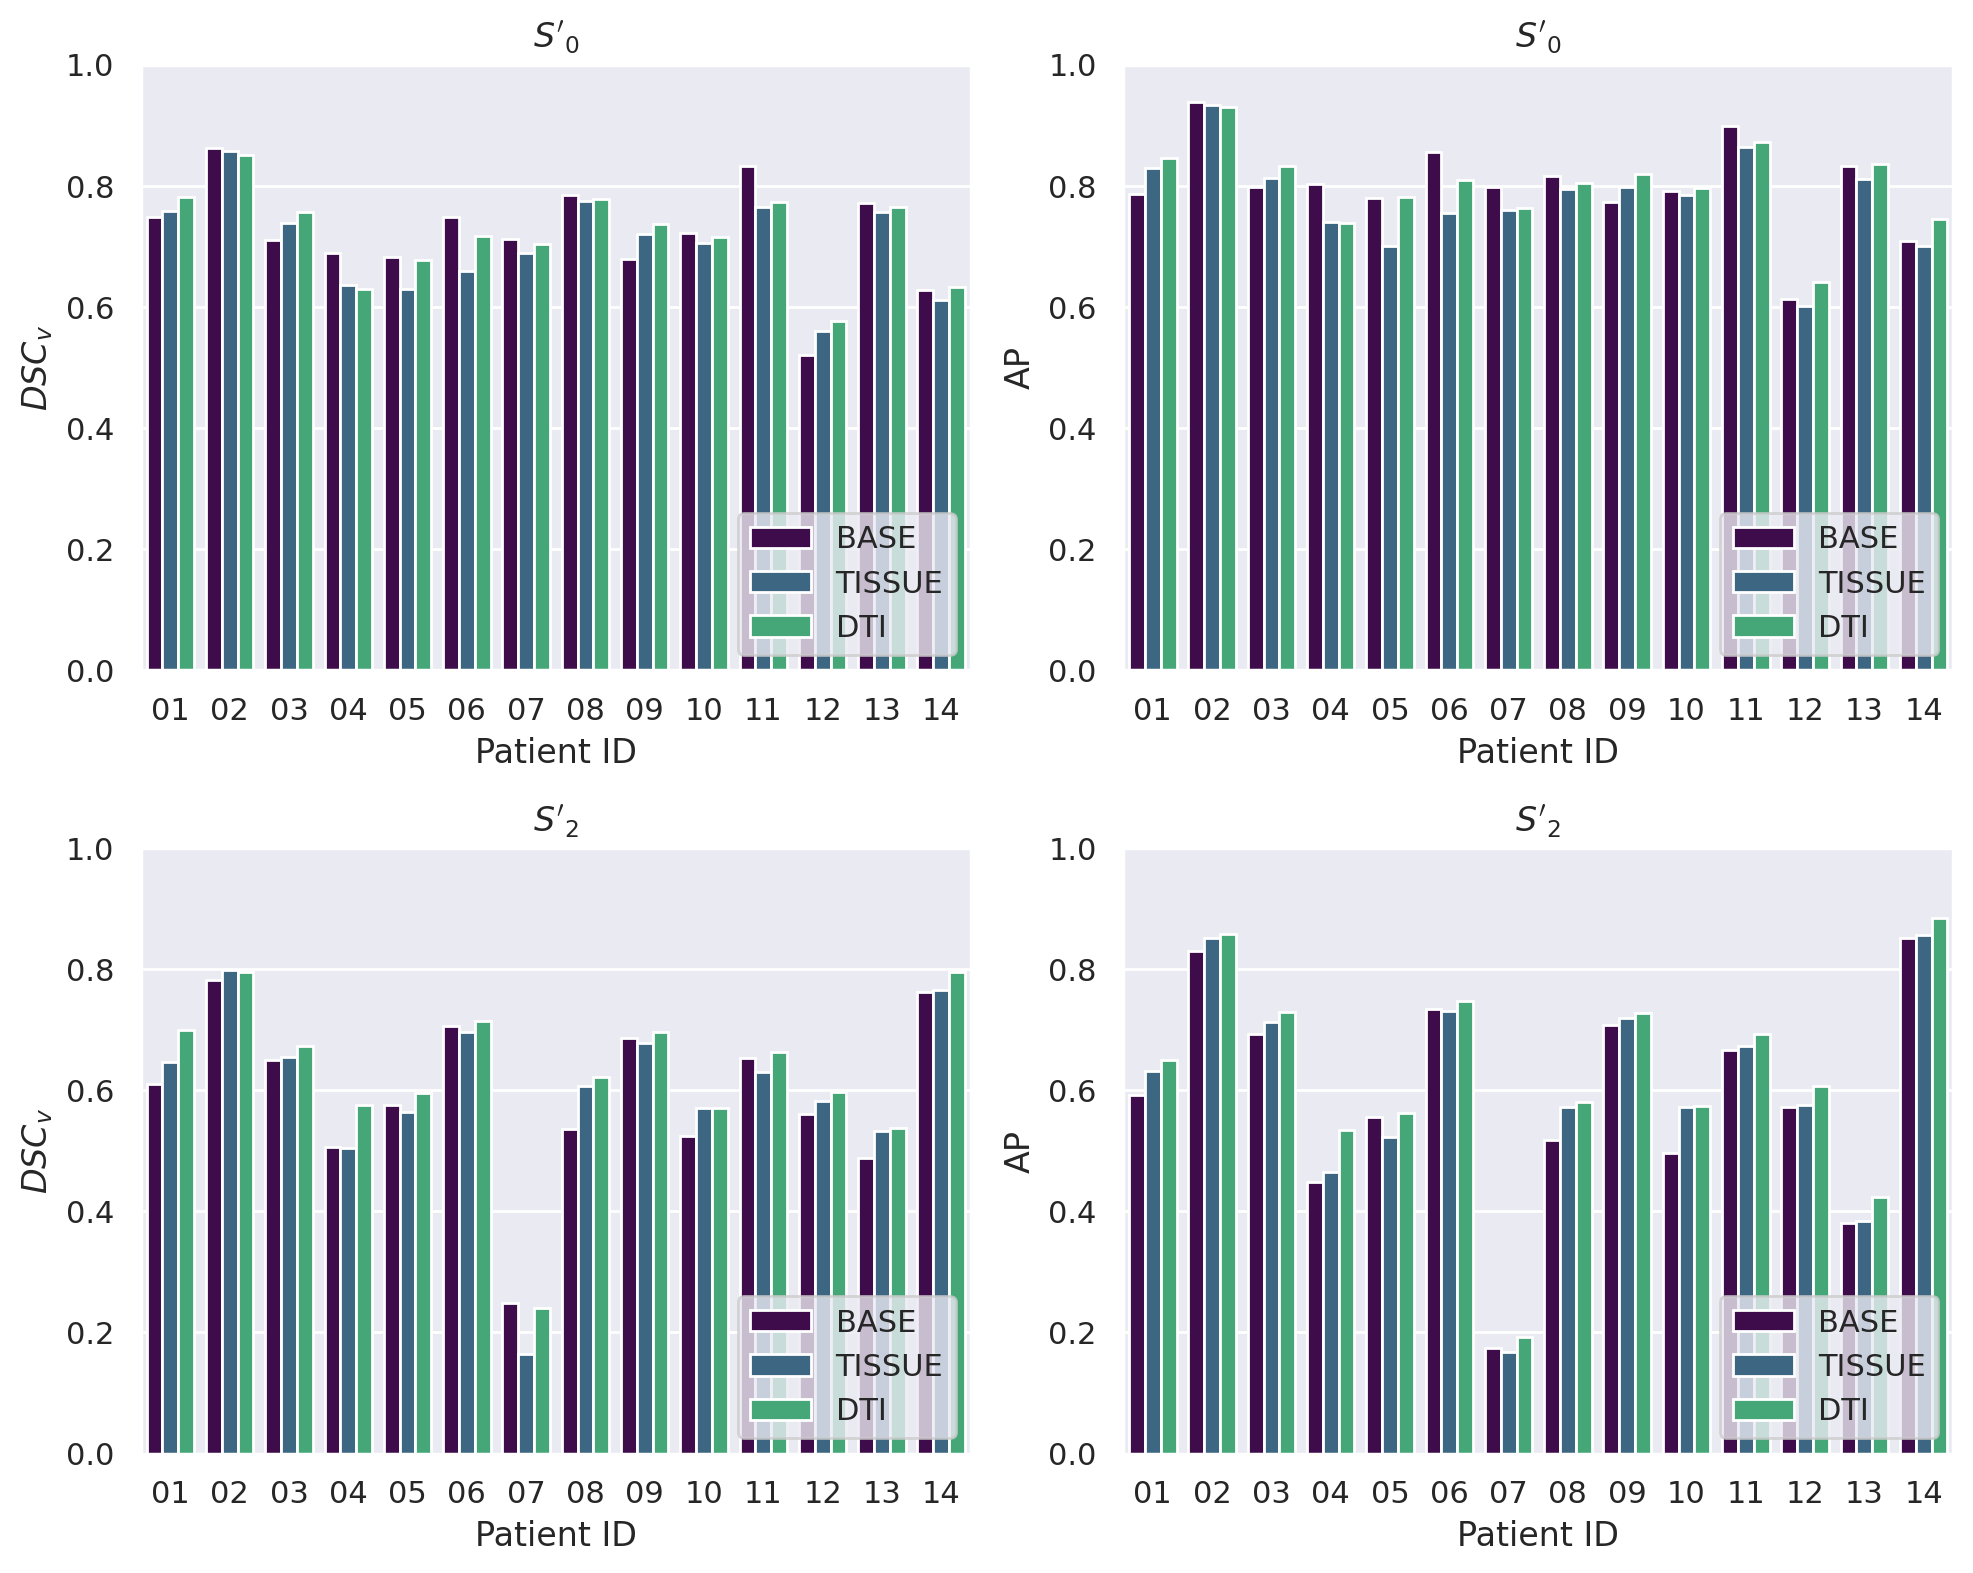

In [6]:
fig, axs = plt.subplots(2,2, figsize=(10,8))
sns.set(rc = {'savefig.dpi': 200, 'figure.dpi': 200})
for ax_i, moment in enumerate(["$S'_0$", "$S'_2$"]):
    print(moment)
    data_followup = df_results.loc[df_results['Moment'] == moment]
    for ax_j, metric in enumerate(['$DSC_v$', 'AP']):
        print(metric)
        
        data_diff = data_followup.loc[data_followup['Method'] == 'BASE'][metric].values
        
        data_dti = data_followup.loc[data_followup['Method'] == 'DTI'][metric].values
        
        data_gm = data_followup.loc[data_followup['Method'] == 'TISSUE'][metric].values
        print(f'Mean BASE performance: {np.mean(data_diff):.2f}')
        print(f'Mean TISSUE performance: {np.mean(data_gm):.2f}')
        print(f'Mean DTI performance: {np.mean(data_dti):.2f}')
        print(f'median BASE performance: {np.median(data_diff):.2f}')
        print(f'median TISSUE performance: {np.median(data_gm):.2f}')
        print(f'median DTI performance: {np.median(data_dti):.2f}')
        print("TISSUE vs BASE")
        print(wilcoxon(data_gm, data_diff))
        print("BASE vs DTI")
        print(wilcoxon(data_dti, data_diff))
        print("DTI vs TISSUE")
        print(wilcoxon(data_gm, data_dti))
    
        sns.barplot(data=data_followup, y=metric, x='Patient', hue='Method',
                    hue_order=['BASE', 'TISSUE', 'DTI'], ax=axs[ax_i, ax_j],
                   palette=colors)
        axs[ax_i, ax_j].set_xlabel('Patient ID')
        axs[ax_i, ax_j].set_xticklabels([s[4:] for s in df_results['Patient'].unique()])
        axs[ax_i, ax_j].set_title(moment)
        axs[ax_i, ax_j].legend(loc='lower right')
        axs[ax_i, ax_j].set_ylim(0,1)
fig.tight_layout(pad=1)
# plt.savefig('figures/performance_per_patient.jpg')
plt.show()
plt.close()

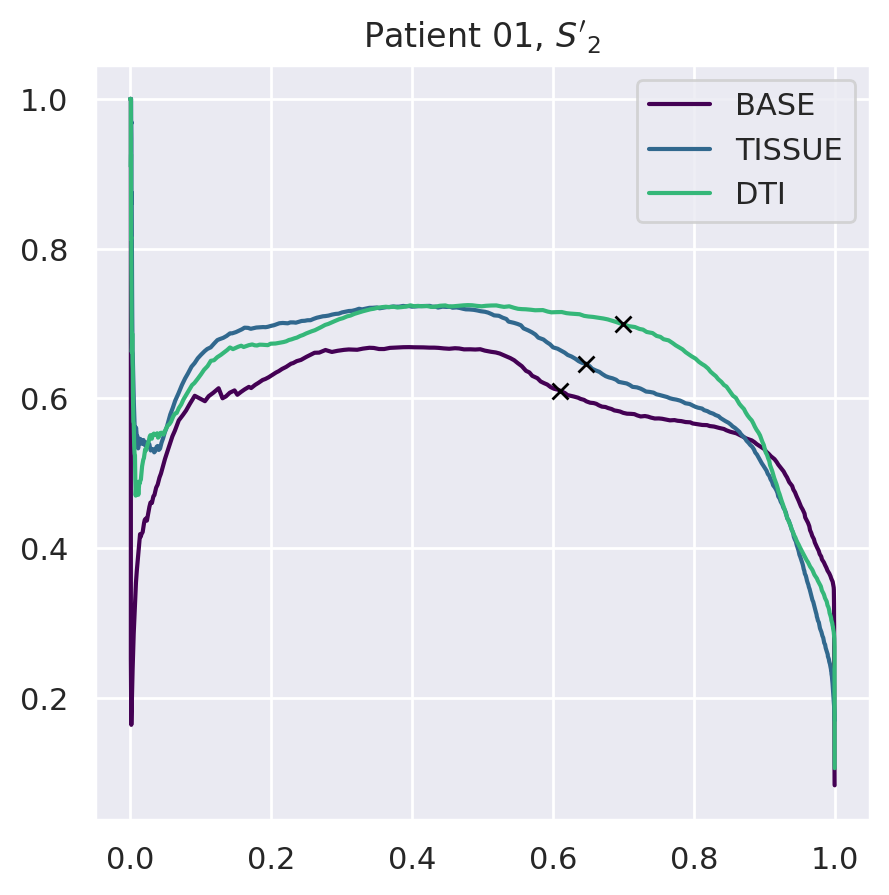

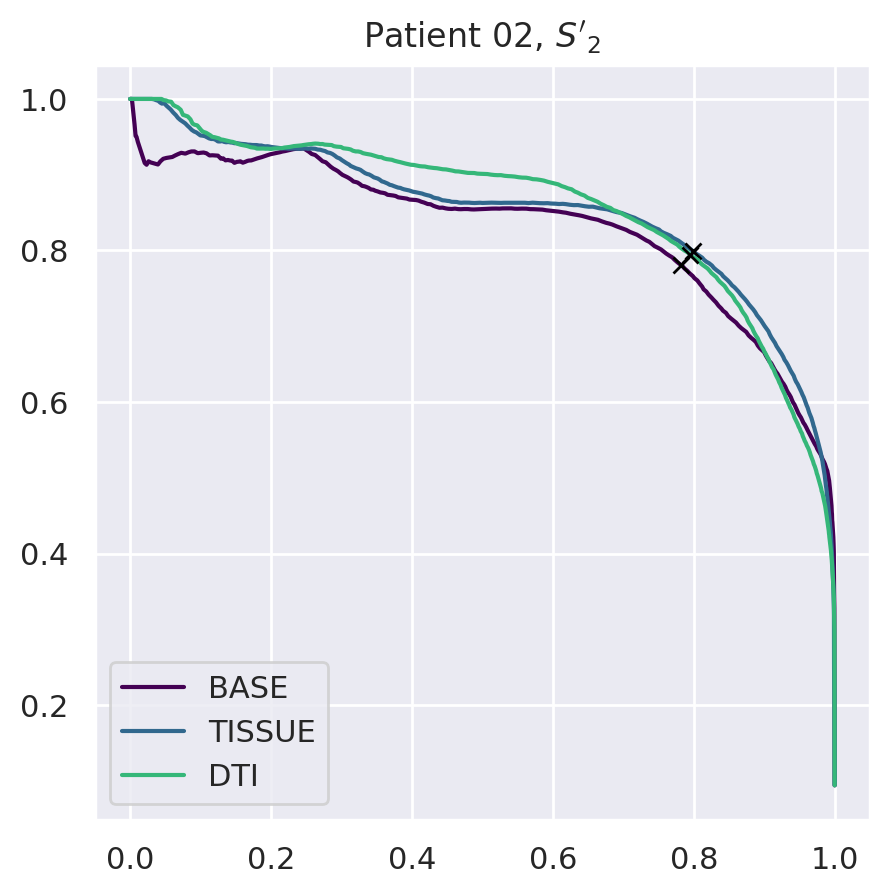

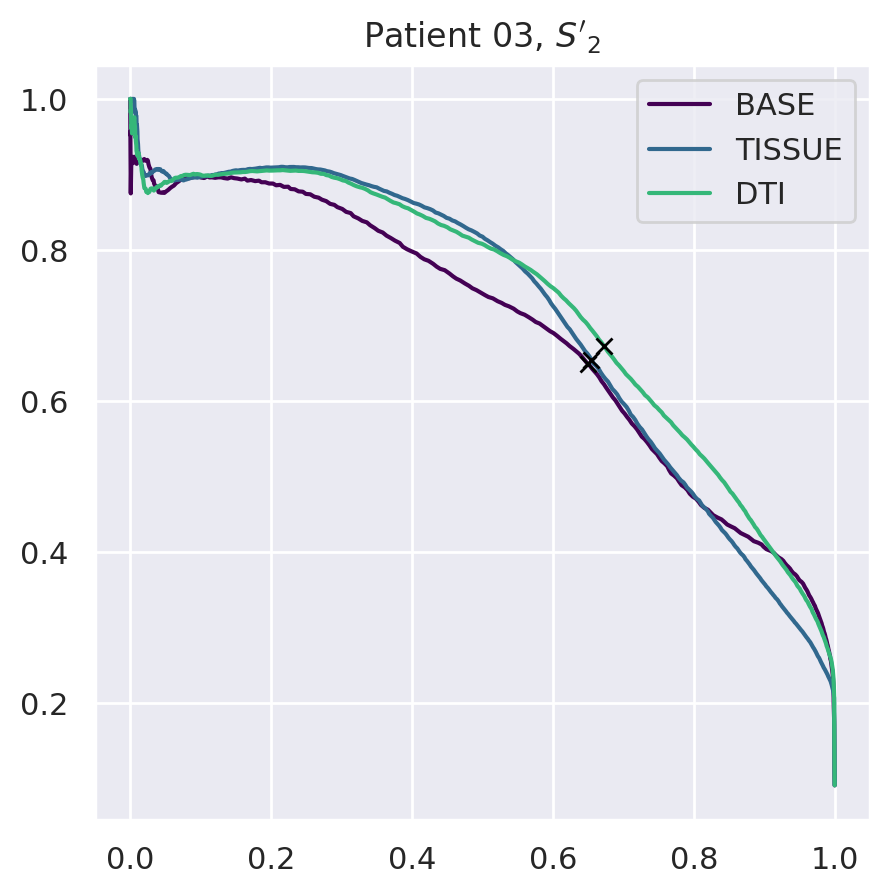

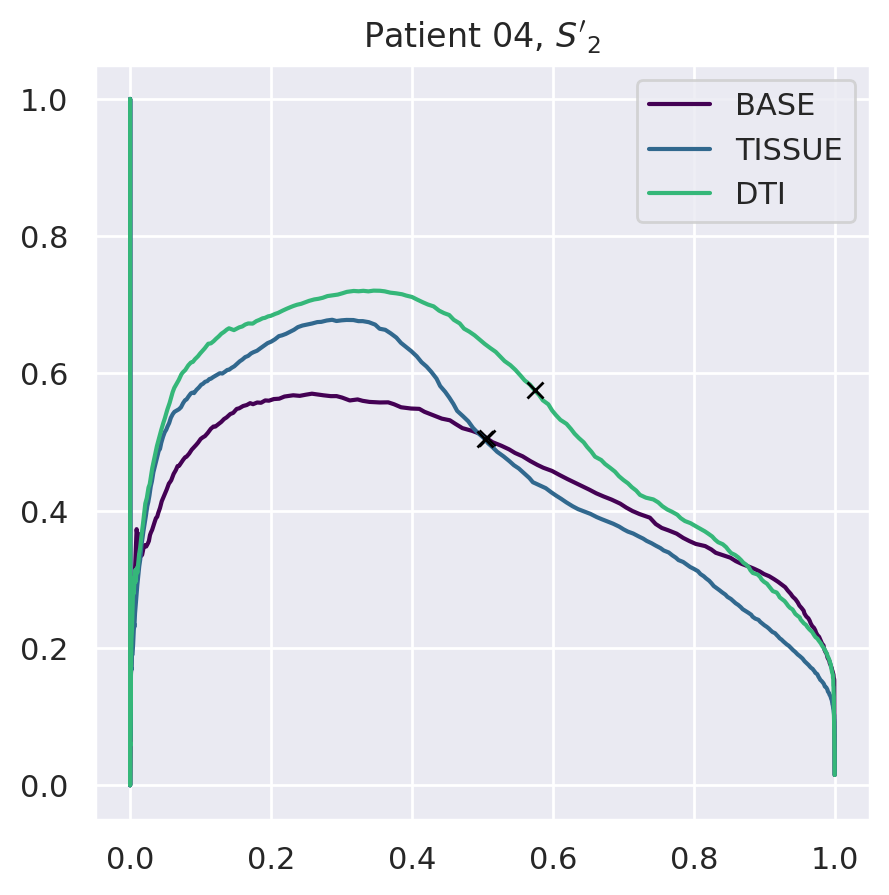

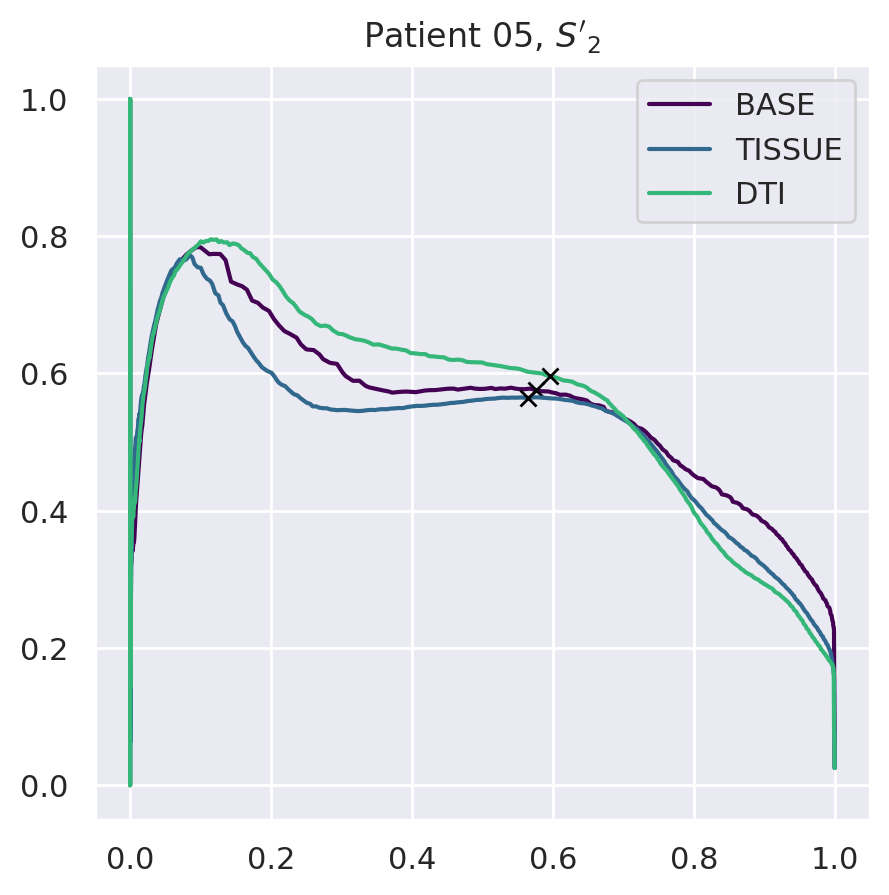

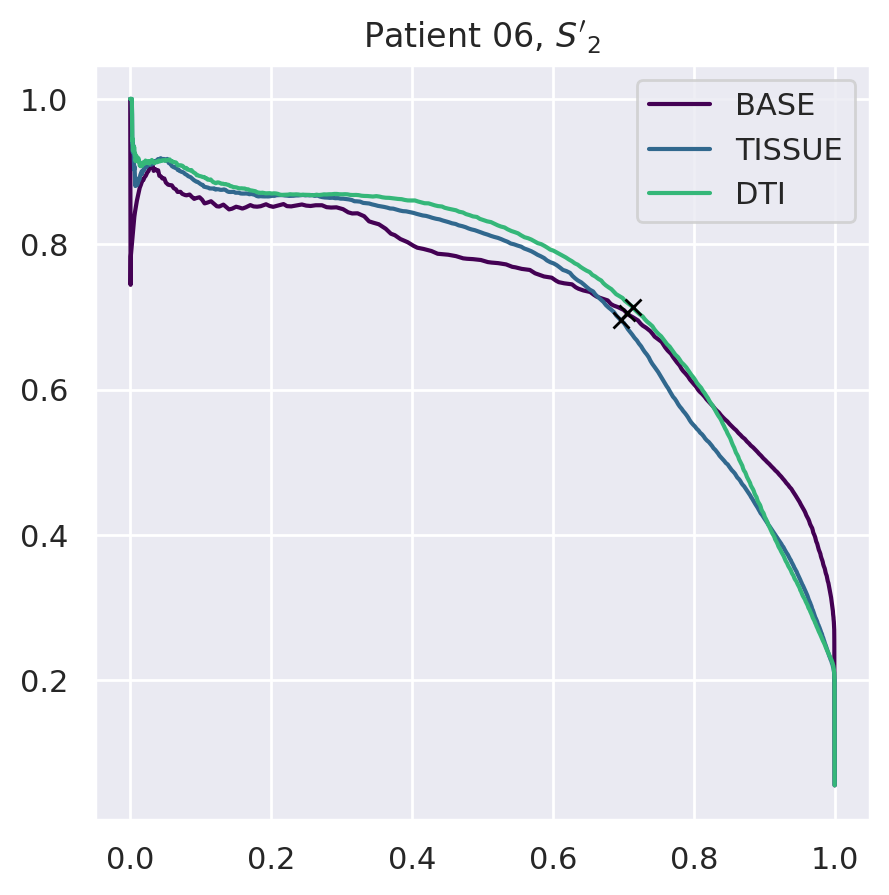

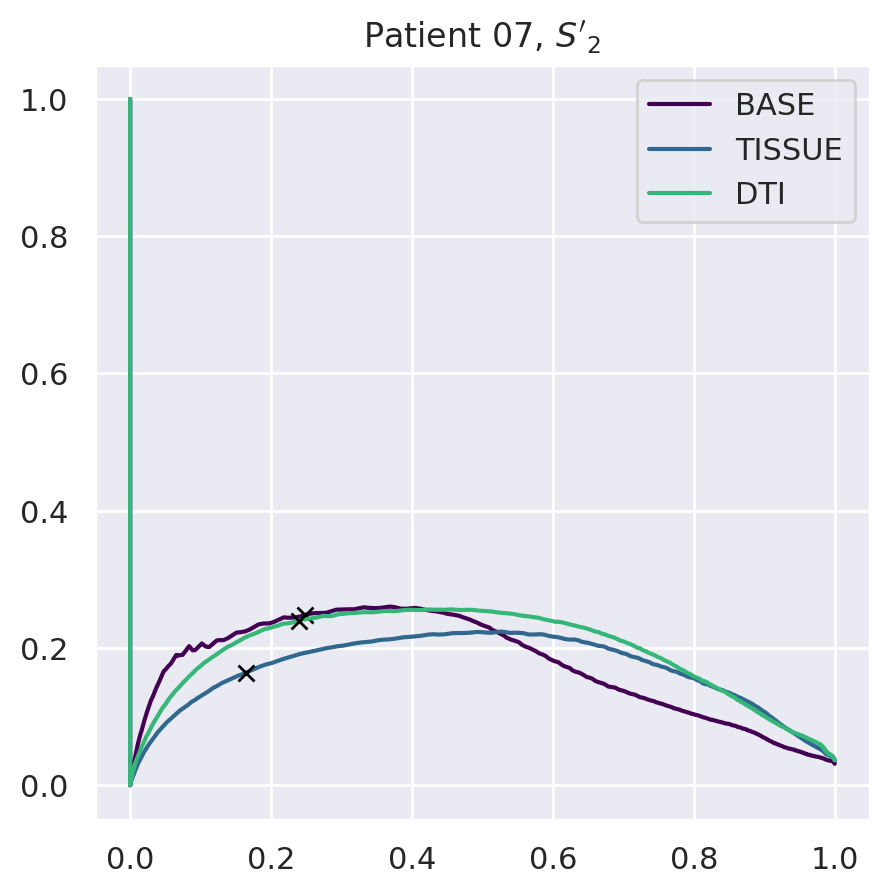

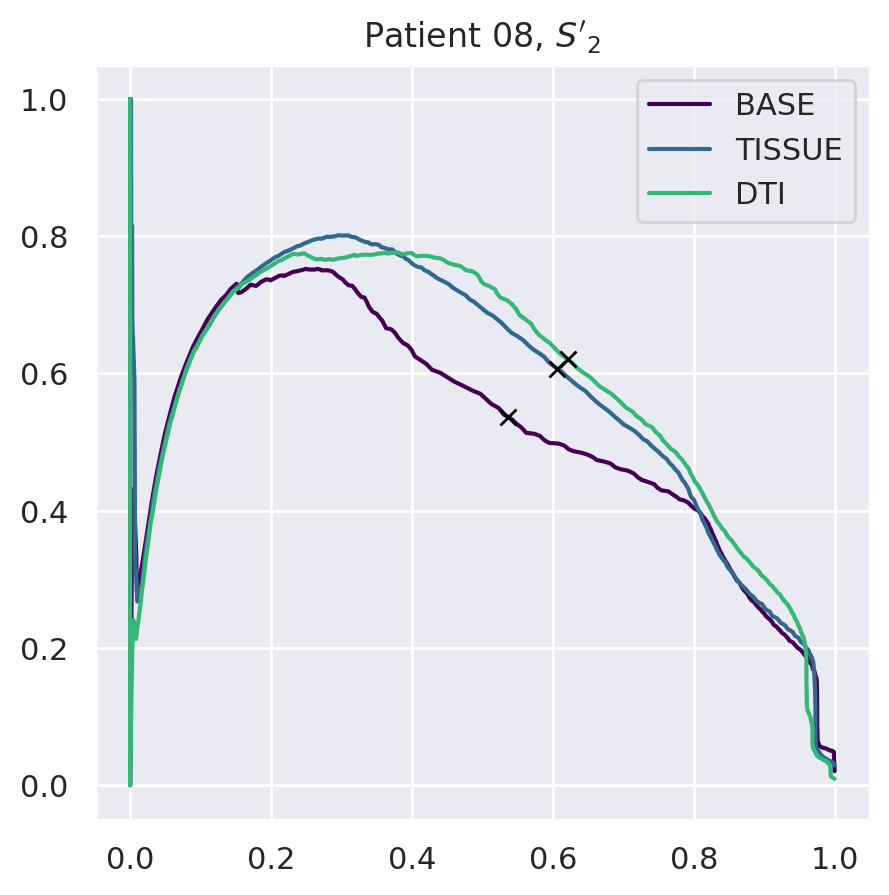

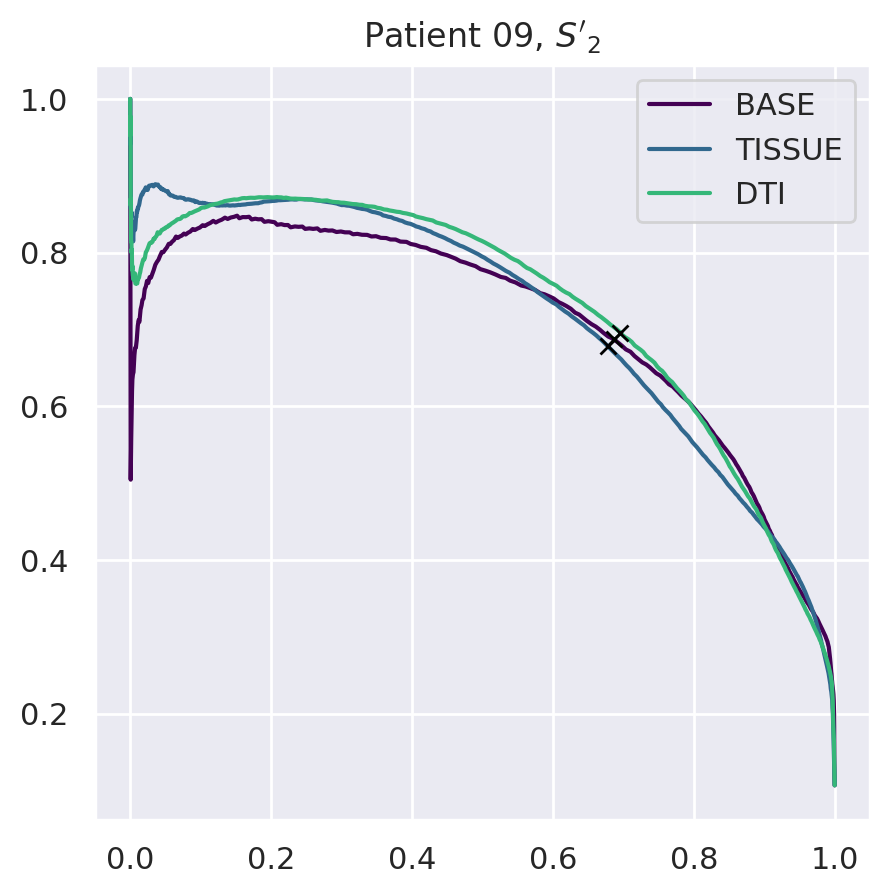

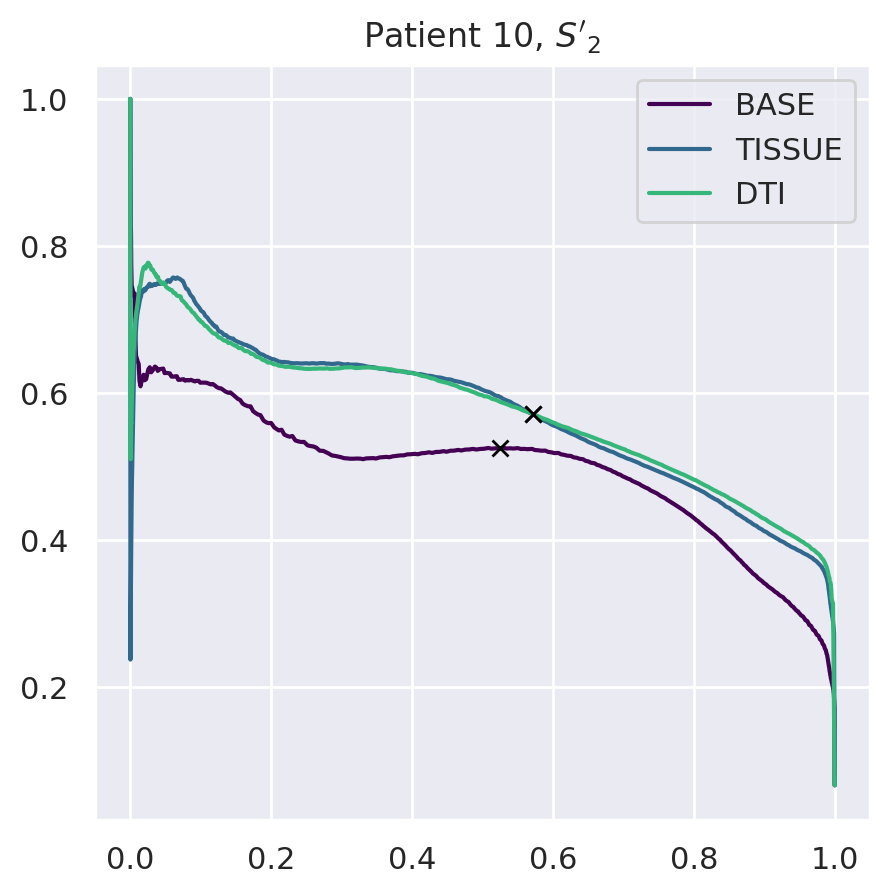

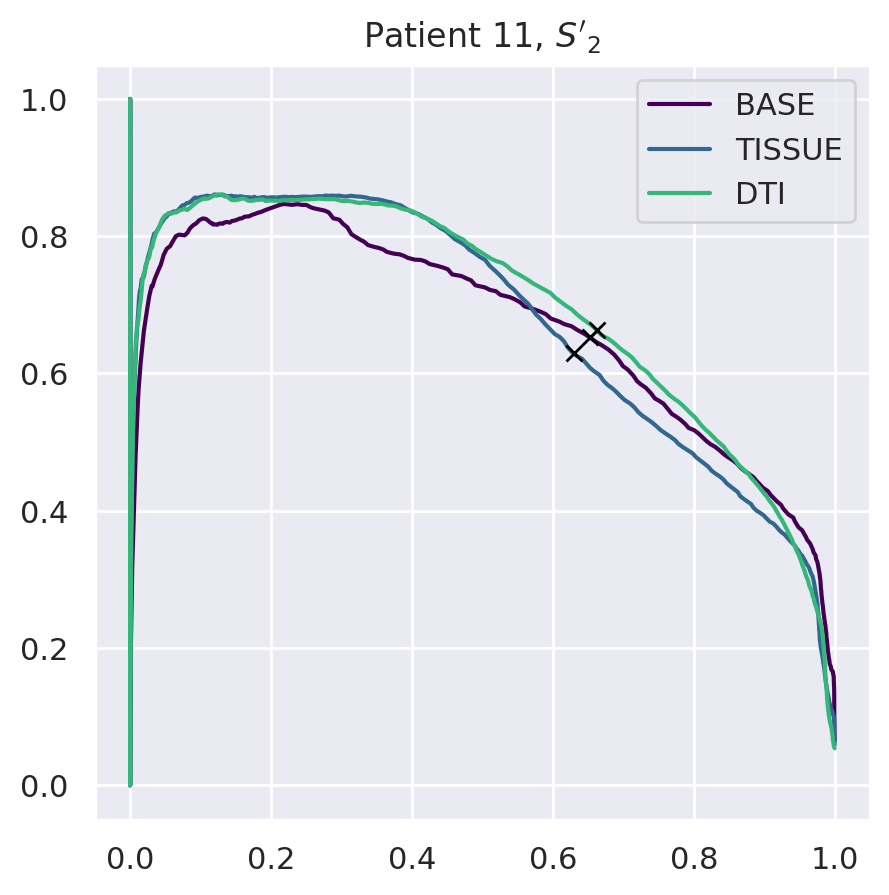

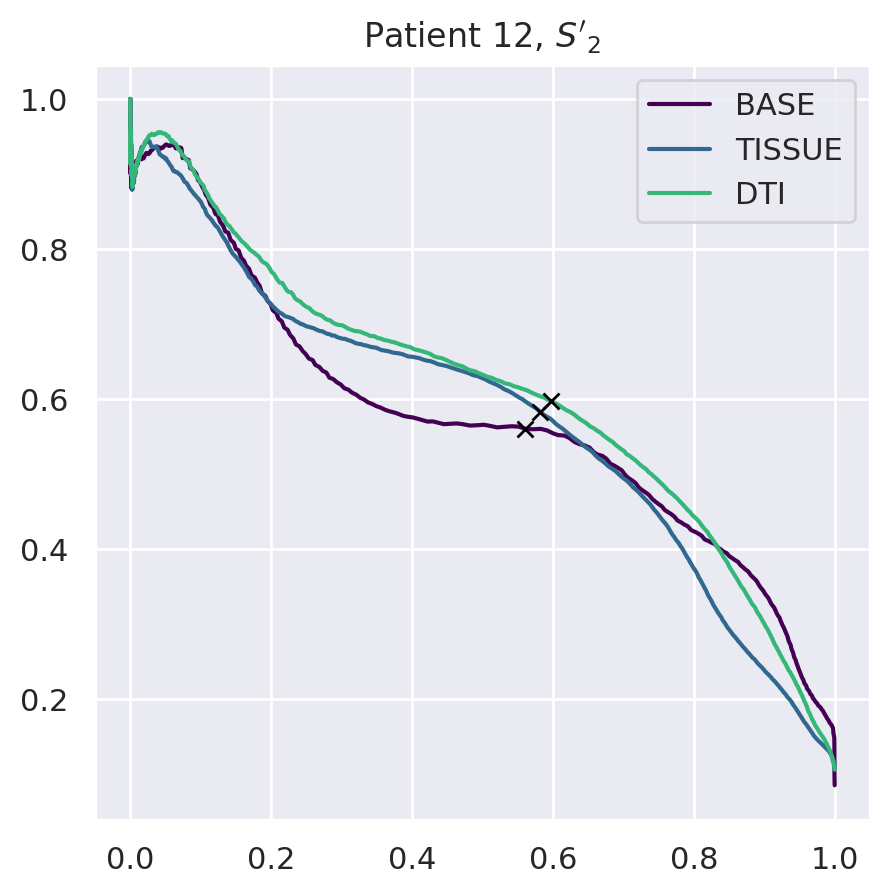

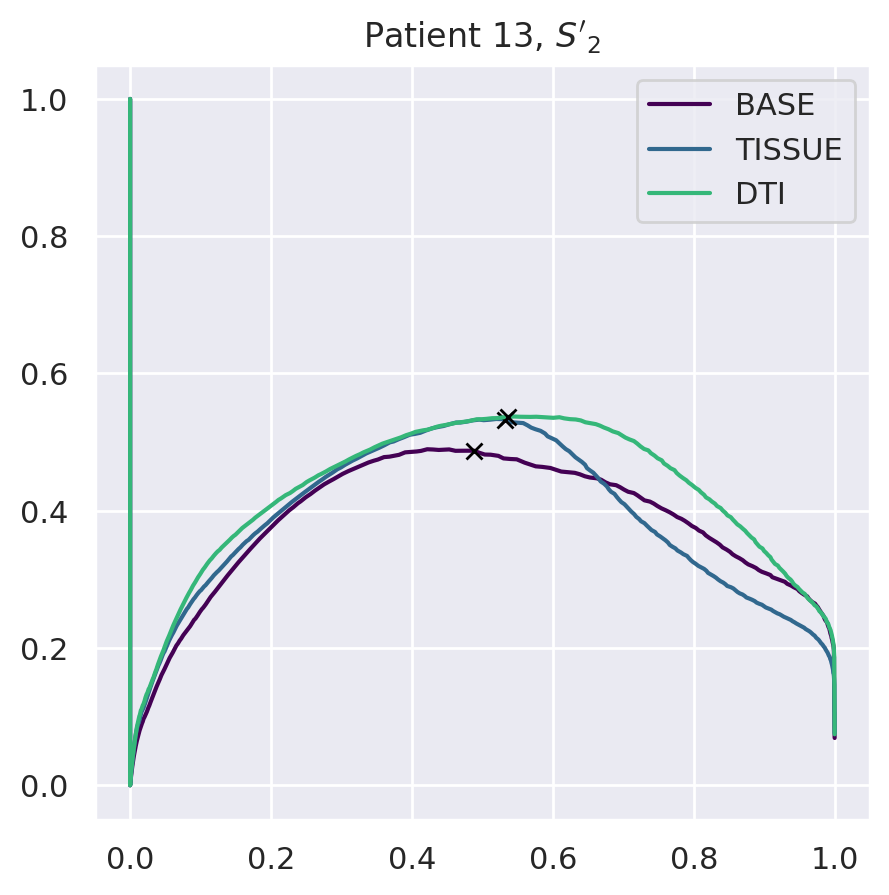

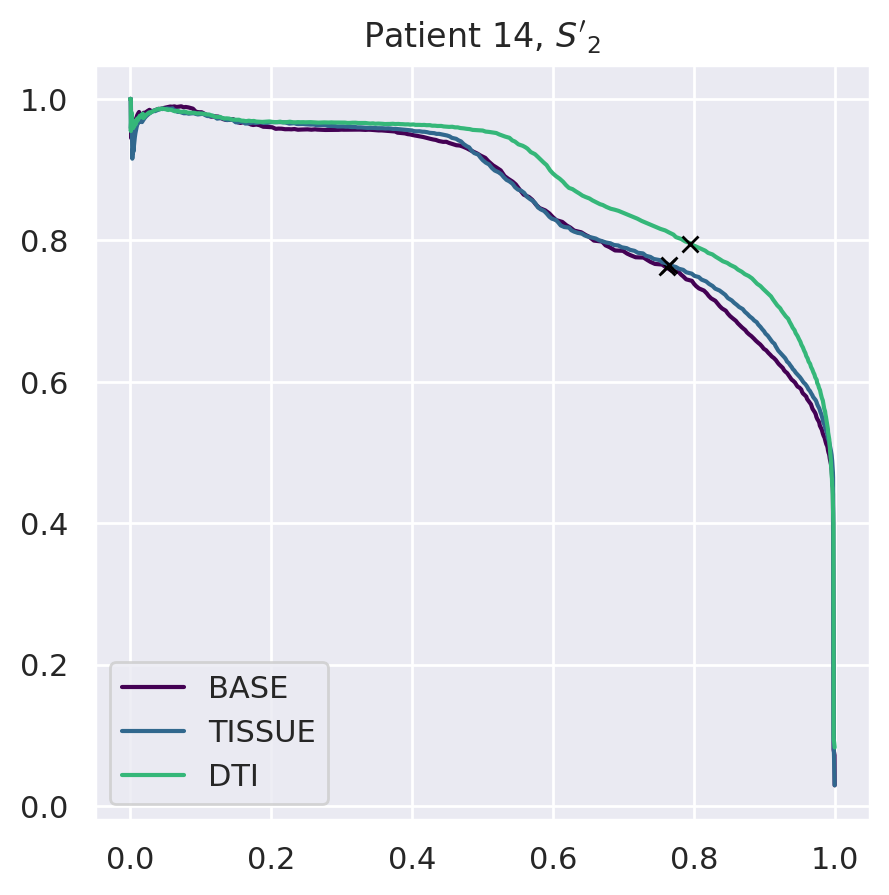

In [32]:
for pat in df_results.Patient.unique(): 
    for i_ax, moment in enumerate(df_results.Moment.unique()):
        for i, model in enumerate(df_results.Method.unique()):
        
        
            selected_res = df_results.loc[df_results.Patient == pat]
            selected_res = selected_res.loc[selected_res.Method == model]
            selected_res = selected_res.loc[selected_res.Moment == moment]
            row = selected_res.iloc[0]

            path_results = segpath = row['logdir']
            segpath = row['segpath']
            
            dscv = row["$DSC_v$"]
            
            if moment == "$S'_2$":
                tissue_path = row['tissue_path']
            else:
                tissue_path = None
            
            tti_arr, seg_array, inclusion_array = get_evaluation_data_from_paths(path_results, segpath, tissue_path)

            precision, recall, thresholds = get_precision_recall_curve(tti_arr, seg_array, inclusion_array > 0.5)
            plt.plot(recall, precision, label=model, color=colors[i])
            plt.plot([dscv], [dscv], 'x', color='black')
            
        plt.legend()
        plt.title(f"Patient {pat[-2:]}, {moment}")
        plt.savefig(f'figures/apcurves/apcurve_{pat[-2:]}_{i_ax}.jpg', bbox_inches='tight')
        plt.show()
        plt.close()
        break